In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'

mixed_playlist = pd.read_csv('data/mixed_playlist.csv')


In [2]:
# To display categories "Users" that exists in the column user
num_categories = mixed_playlist.user.unique()

In [3]:
mapping = {'unknown': 0, 'delta': 1, 'gamma': 2, 'alpha': 3, 'dzeta': 4, 'beta': 5, 'epsilon': 6}
mixed_playlist['user'] = mixed_playlist['user'].replace(mapping)
mixed_playlist.user

0       0
1       1
2       2
3       2
4       3
       ..
3894    5
3895    1
3896    4
3897    5
3898    0
Name: user, Length: 3899, dtype: int64

In [4]:
# Replace 'unknown' values in 'top_year' column with 0
mixed_playlist['top_year'] = mixed_playlist['top_year'].replace('unknown', 0)

mixed_playlist.top_year

0          0
1       2022
2       2020
3       2018
4       2020
        ... 
3894    2020
3895    2020
3896    2021
3897    2018
3898       0
Name: top_year, Length: 3899, dtype: object

In [5]:
mixed_playlist.info()
mixed_playlist.dropna(inplace=True)

# display the descriptive statistics of numeric variables
mixed_playlist.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3899 entries, 0 to 3898
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3890 non-null   object 
 1   album             3890 non-null   object 
 2   artist            3899 non-null   object 
 3   release_date      3899 non-null   object 
 4   length            3899 non-null   int64  
 5   popularity        3899 non-null   int64  
 6   acousticness      3899 non-null   float64
 7   danceability      3899 non-null   float64
 8   energy            3899 non-null   float64
 9   instrumentalness  3899 non-null   float64
 10  liveness          3899 non-null   float64
 11  loudness          3899 non-null   float64
 12  speechiness       3899 non-null   float64
 13  tempo             3899 non-null   float64
 14  valence           3899 non-null   float64
 15  time_signature    3899 non-null   int64  
 16  key               3899 non-null   int64  


,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,release_year,user
count,3.890000e+03,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000
mean,2.444187e+05,32.005398,0.425120,0.554521,0.523066,0.296768,0.167134,-10.436968,0.085179,115.826347,0.384641,3.873779,5.295630,0.466838,2012.748072,3.357326
std,1.045747e+05,24.920088,0.363021,0.192029,0.265409,0.386456,0.143656,6.209512,0.092698,28.662454,0.254691,0.465588,3.507038,0.498963,10.418784,1.844656
min,3.105300e+04,0.000000,0.000001,0.000000,0.000545,0.000000,0.017900,-42.117000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1957.000000,0.000000
25%,1.880332e+05,1.000000,0.058025,0.424250,0.313000,0.000004,0.094500,-12.790000,0.036800,94.546750,0.161000,4.000000,2.000000,0.000000,2012.000000,2.000000
50%,2.242485e+05,34.000000,0.339000,0.575000,0.547500,0.005730,0.112000,-8.589000,0.047000,115.151500,0.355000,4.000000,5.000000,0.000000,2016.000000,3.000000
75%,2.744900e+05,51.000000,0.793000,0.701000,0.738750,0.773000,0.172000,-6.222500,0.086775,131.986750,0.572000,4.000000,8.000000,1.000000,2018.000000,5.000000
max,1.921683e+06,91.000000,0.996000,0.971000,0.995000,0.995000,0.991000,0.532000,0.952000,209.596000,0.981000,5.000000,11.000000,1.000000,2022.000000,6.000000


In [6]:
# display the correlation matrix between numeric variables
corr = mixed_playlist.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,release_year,user
length,1.000000,-0.095678,0.008430,-0.127790,-0.025789,0.168193,-0.012691,-0.069277,-0.034805,-0.003102,-0.196543,-0.023020,-0.026732,0.018647,-0.134922,-0.002029
popularity,-0.095678,1.000000,-0.031579,0.059827,0.049838,-0.130565,-0.053067,0.095978,0.039192,0.022633,0.034257,-0.013903,0.004236,-0.008805,0.018607,-0.114075
acousticness,0.008430,-0.031579,1.000000,-0.385711,-0.799091,0.163068,-0.118148,-0.688113,-0.163287,-0.186696,-0.270082,-0.225935,-0.041198,-0.014634,-0.194986,-0.165433
danceability,-0.127790,0.059827,-0.385711,1.000000,0.420806,-0.371521,0.007763,0.489680,0.250873,0.084809,0.573579,0.242775,0.024329,-0.015994,0.122880,-0.080037
energy,-0.025789,0.049838,-0.799091,0.420806,1.000000,-0.214224,0.160296,0.827295,0.231508,0.207777,0.422506,0.229897,0.053166,-0.021008,0.203005,0.121438
instrumentalness,0.168193,-0.130565,0.163068,-0.371521,-0.214224,1.000000,-0.091973,-0.411947,-0.256769,-0.035079,-0.407290,-0.113255,-0.000996,0.004675,0.012262,0.171177
liveness,-0.012691,-0.053067,-0.118148,0.007763,0.160296,-0.091973,1.000000,0.095043,0.111733,0.037593,0.115369,-0.013280,0.008491,0.006520,-0.025289,-0.031247
loudness,-0.069277,0.095978,-0.688113,0.489680,0.827295,-0.411947,0.095043,1.000000,0.191693,0.184570,0.428280,0.235168,0.039602,-0.005157,0.231127,0.048809
speechiness,-0.034805,0.039192,-0.163287,0.250873,0.231508,-0.256769,0.111733,0.191693,1.000000,0.036513,0.250839,0.067924,0.017841,-0.033367,0.097793,-0.095971
tempo,-0.003102,0.022633,-0.186696,0.084809,0.207777,-0.035079,0.037593,0.184570,0.036513,1.000000,0.089352,0.006864,0.019338,-0.057536,0.038141,0.013110


In [7]:
correlation_matrix = mixed_playlist.corr()
# You can set a threshold for correlation values and remove features with high correlation
threshold = 0.7  # Adjust this threshold as needed
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

mixed_playlist.drop(highly_correlated_features, axis=1, inplace=True)

In [8]:
#Complete model with top year and user (experimental)
mixed_playlist_complete =  mixed_playlist.copy()
irrelevant_features_complete = ['name', 'album', 'artist','release_date','uri']
mixed_playlist_complete.drop(irrelevant_features_complete, axis=1, inplace=True)
mixed_playlist_complete = mixed_playlist_complete[mixed_playlist_complete['top_year'] != 0]
mixed_playlist_complete

,length,popularity,acousticness,danceability,instrumentalness,liveness,speechiness,tempo,valence,time_signature,key,mode,release_year,top_year,user
1,172626,62,0.622000,0.615,0.000008,0.1920,0.2530,86.976,0.626,4,1,1,2018,2022,1
2,175269,72,0.413000,0.834,0.000040,0.1130,0.3410,89.989,0.356,4,6,0,2019,2020,2
3,175266,0,0.404000,0.797,0.000153,0.2550,0.0327,128.027,0.539,4,5,0,2018,2018,2
4,264735,53,0.061600,0.788,0.711000,0.1000,0.0318,107.993,0.525,4,7,0,2016,2020,3
5,256906,0,0.419000,0.677,0.080200,0.1080,0.0501,143.219,0.552,4,2,0,2017,2018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3893,160000,82,0.650000,0.709,0.000002,0.1330,0.3530,83.995,0.543,4,10,1,2020,2021,2
3894,324133,41,0.992000,0.529,0.922000,0.1100,0.0575,115.924,0.585,4,0,0,1962,2020,5
3895,185506,0,0.942000,0.417,0.001700,0.1250,0.0871,76.774,0.505,3,4,0,2019,2020,1
3896,352105,51,0.000016,0.467,0.908000,0.0856,0.0414,122.004,0.061,4,0,0,2017,2021,4


In [9]:
test_df = mixed_playlist_complete.copy()

In [10]:
#Complete model with top year and user (experimental)
scaler_complete = MinMaxScaler()
mixed_playlist_scaled_complete= scaler_complete.fit_transform(mixed_playlist_complete)
mixed_playlist_complete = pd.DataFrame(mixed_playlist_scaled_complete, columns=mixed_playlist_complete.columns)
mixed_playlist_complete



,length,popularity,acousticness,danceability,instrumentalness,liveness,speechiness,tempo,valence,time_signature,key,mode,release_year,top_year,user
0,0.074881,0.681319,0.624497,0.633368,0.000008,0.178913,0.265756,0.414970,0.638124,0.8,0.090909,1.0,0.938462,1.000000,0.0
1,0.076279,0.791209,0.414658,0.858908,0.000040,0.097729,0.358193,0.429345,0.362895,0.8,0.545455,0.0,0.953846,0.666667,0.2
2,0.076278,0.000000,0.405622,0.820803,0.000154,0.243654,0.034349,0.610827,0.549439,0.8,0.454545,0.0,0.938462,0.333333,0.2
3,0.123600,0.582418,0.061846,0.811535,0.714573,0.084370,0.033403,0.515244,0.535168,0.8,0.636364,0.0,0.907692,0.666667,0.4
4,0.119459,0.000000,0.420682,0.697219,0.080603,0.092591,0.052626,0.683310,0.562691,0.8,0.181818,0.0,0.923077,0.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3785,0.068203,0.901099,0.652610,0.730175,0.000002,0.118282,0.370798,0.400747,0.553517,0.8,0.909091,1.0,0.969231,0.833333,0.2
3786,0.155017,0.450549,0.995984,0.544799,0.926633,0.094646,0.060399,0.553083,0.596330,0.8,0.000000,0.0,0.076923,0.666667,0.8
3787,0.081694,0.000000,0.945783,0.429454,0.001709,0.110061,0.091492,0.366295,0.514781,0.6,0.363636,0.0,0.953846,0.666667,0.0
3788,0.169812,0.560440,0.000015,0.480947,0.912563,0.069571,0.043487,0.582091,0.062181,0.8,0.000000,0.0,0.923077,0.833333,0.6


In [11]:
X_complete = mixed_playlist_complete.values
model_complete = KMeans(
    n_clusters = 6, # 6 clusters referred to 6 users 'delta': 1, 'gamma': 2, 'alpha': 3, 'dzeta': 4, 'beta': 5, 'epsilon': 6
    n_init = 'auto', # multiple attempt with different initial centroids
    random_state = 1, # fix ramdom state to guarantee reproducibility
    verbose = 1 # output log
)
model_complete.fit(X_complete)
model_complete.cluster_centers_

cluster_centers_complete = pd.DataFrame(
    model_complete.cluster_centers_,
    columns = mixed_playlist_complete.columns
)
cluster_centers_complete


Initialization complete
Iteration 0, inertia 3612.9410494255076.
Iteration 1, inertia 2639.461059412707.
Iteration 2, inertia 2560.272988892831.
Iteration 3, inertia 2541.7219312920565.
Iteration 4, inertia 2530.736936854081.
Iteration 5, inertia 2513.7295071802164.
Iteration 6, inertia 2503.4937057184316.
Iteration 7, inertia 2495.1085980511284.
Iteration 8, inertia 2487.50930893064.
Iteration 9, inertia 2480.849906936668.
Iteration 10, inertia 2472.989049369381.
Iteration 11, inertia 2459.9163550959474.
Iteration 12, inertia 2451.3227987454907.
Iteration 13, inertia 2448.618551121554.
Iteration 14, inertia 2447.6900176603267.
Iteration 15, inertia 2446.575720896585.
Iteration 16, inertia 2444.1140181044616.
Iteration 17, inertia 2438.995486830374.
Iteration 18, inertia 2434.736333164763.
Iteration 19, inertia 2432.4092222669346.
Iteration 20, inertia 2430.7806531628326.
Iteration 21, inertia 2429.288949224254.
Iteration 22, inertia 2428.227911147403.
Iteration 23, inertia 2427.887953

,length,popularity,acousticness,danceability,instrumentalness,liveness,speechiness,tempo,valence,time_signature,key,mode,release_year,top_year,user
0,0.103296,0.394376,0.466049,0.643398,0.029767,0.155401,0.115757,0.560991,0.507081,0.780103,0.516457,9.992007e-16,0.861523,0.530256,0.215795
1,0.101471,0.591808,0.341898,0.633361,0.036167,0.152761,0.109574,0.554964,0.454239,0.779636,0.427769,1.000000e+00,0.891329,0.766364,0.405091
2,0.121268,0.339543,0.836552,0.367095,0.808790,0.114529,0.047548,0.520103,0.171206,0.730481,0.464511,4.440892e-16,0.824640,0.636809,0.574332
3,0.116047,0.306607,0.126596,0.594219,0.375778,0.169693,0.086927,0.582225,0.378152,0.790419,0.563827,7.771561e-16,0.901796,0.513972,0.795808
4,0.112164,0.206910,0.405477,0.609096,0.048246,0.172091,0.091554,0.544018,0.451076,0.786970,0.415427,1.000000e+00,0.806853,0.215404,0.510606
5,0.123439,0.287900,0.492749,0.463686,0.830958,0.131410,0.057794,0.539230,0.231296,0.761279,0.455353,1.000000e+00,0.860773,0.591770,0.599290


In [12]:
# It is considered Irrelevant features every description or string that does not contribute in understanding the nature of the song
irrelevant_features = ['name', 'album', 'artist','release_date','uri', 'top_year']  # Modify this list with your irrelevant feature names
mixed_playlist.drop(irrelevant_features, axis=1, inplace=True)


In [13]:
mixed_playlist

,length,popularity,acousticness,danceability,instrumentalness,liveness,speechiness,tempo,valence,time_signature,key,mode,release_year,user
0,76933,53,0.996000,0.329,0.866000,0.0906,0.0448,70.295,0.238,4,11,0,1996,0
1,172626,62,0.622000,0.615,0.000008,0.1920,0.2530,86.976,0.626,4,1,1,2018,1
2,175269,72,0.413000,0.834,0.000040,0.1130,0.3410,89.989,0.356,4,6,0,2019,2
3,175266,0,0.404000,0.797,0.000153,0.2550,0.0327,128.027,0.539,4,5,0,2018,2
4,264735,53,0.061600,0.788,0.711000,0.1000,0.0318,107.993,0.525,4,7,0,2016,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3894,324133,41,0.992000,0.529,0.922000,0.1100,0.0575,115.924,0.585,4,0,0,1962,5
3895,185506,0,0.942000,0.417,0.001700,0.1250,0.0871,76.774,0.505,3,4,0,2019,1
3896,352105,51,0.000016,0.467,0.908000,0.0856,0.0414,122.004,0.061,4,0,0,2017,4
3897,154826,16,0.045300,0.589,0.008480,0.1020,0.0569,182.051,0.658,4,6,1,2017,5


In [14]:
mixed_playlist['user'].value_counts().get(0)

100

In [15]:
# Extracting rows where 'user' is 0 into a new DataFrame
unknown_df = mixed_playlist[mixed_playlist['user'] == 0]

In [16]:
unknown_df

,length,popularity,acousticness,danceability,instrumentalness,liveness,speechiness,tempo,valence,time_signature,key,mode,release_year,user
0,76933,53,0.996,0.329,0.86600,0.0906,0.0448,70.295,0.2380,4,11,0,1996,0
75,183773,22,0.994,0.629,0.94700,0.0864,0.0406,111.454,0.2410,4,0,0,2018,0
80,551666,20,0.981,0.208,0.91900,0.0843,0.0342,62.543,0.0420,4,4,1,1998,0
92,321146,26,0.870,0.258,0.89800,0.1480,0.0381,98.874,0.0378,4,5,0,2019,0
150,1009706,27,0.913,0.502,0.85700,0.0914,0.0473,105.740,0.5590,4,7,0,1992,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,160826,34,0.960,0.443,0.91700,0.1100,0.0516,117.938,0.1510,3,4,0,1997,0
3725,165626,32,0.996,0.912,0.74100,0.1150,0.0572,117.872,0.9490,4,9,0,2003,0
3761,175680,36,0.982,0.146,0.93300,0.0748,0.0401,76.216,0.0393,4,5,0,2008,0
3802,150000,0,0.984,0.157,0.06610,0.2760,0.0394,156.875,0.0378,1,6,0,1999,0


In [17]:
# Removing these rows from the original mixed_playlist DataFrame
mixed_playlist = mixed_playlist[mixed_playlist['user'] != 0]

In [18]:
mixed_playlist

,length,popularity,acousticness,danceability,instrumentalness,liveness,speechiness,tempo,valence,time_signature,key,mode,release_year,user
1,172626,62,0.622000,0.615,0.000008,0.1920,0.2530,86.976,0.626,4,1,1,2018,1
2,175269,72,0.413000,0.834,0.000040,0.1130,0.3410,89.989,0.356,4,6,0,2019,2
3,175266,0,0.404000,0.797,0.000153,0.2550,0.0327,128.027,0.539,4,5,0,2018,2
4,264735,53,0.061600,0.788,0.711000,0.1000,0.0318,107.993,0.525,4,7,0,2016,3
5,256906,0,0.419000,0.677,0.080200,0.1080,0.0501,143.219,0.552,4,2,0,2017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3893,160000,82,0.650000,0.709,0.000002,0.1330,0.3530,83.995,0.543,4,10,1,2020,2
3894,324133,41,0.992000,0.529,0.922000,0.1100,0.0575,115.924,0.585,4,0,0,1962,5
3895,185506,0,0.942000,0.417,0.001700,0.1250,0.0871,76.774,0.505,3,4,0,2019,1
3896,352105,51,0.000016,0.467,0.908000,0.0856,0.0414,122.004,0.061,4,0,0,2017,4


In [19]:
del mixed_playlist['user']

In [20]:
mixed_playlist

,length,popularity,acousticness,danceability,instrumentalness,liveness,speechiness,tempo,valence,time_signature,key,mode,release_year
1,172626,62,0.622000,0.615,0.000008,0.1920,0.2530,86.976,0.626,4,1,1,2018
2,175269,72,0.413000,0.834,0.000040,0.1130,0.3410,89.989,0.356,4,6,0,2019
3,175266,0,0.404000,0.797,0.000153,0.2550,0.0327,128.027,0.539,4,5,0,2018
4,264735,53,0.061600,0.788,0.711000,0.1000,0.0318,107.993,0.525,4,7,0,2016
5,256906,0,0.419000,0.677,0.080200,0.1080,0.0501,143.219,0.552,4,2,0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3893,160000,82,0.650000,0.709,0.000002,0.1330,0.3530,83.995,0.543,4,10,1,2020
3894,324133,41,0.992000,0.529,0.922000,0.1100,0.0575,115.924,0.585,4,0,0,1962
3895,185506,0,0.942000,0.417,0.001700,0.1250,0.0871,76.774,0.505,3,4,0,2019
3896,352105,51,0.000016,0.467,0.908000,0.0856,0.0414,122.004,0.061,4,0,0,2017


In [21]:
# Feauture Scaling for known data
scaler_unknown = MinMaxScaler()
unknown_scaled = scaler_unknown.fit_transform(unknown_df)
unknown_df = pd.DataFrame(unknown_scaled, columns=unknown_df.columns)
unknown_df

,length,popularity,acousticness,danceability,instrumentalness,liveness,speechiness,tempo,valence,time_signature,key,mode,release_year,user
0,0.003519,0.883333,1.000000,0.312419,0.898340,0.036596,0.046573,0.073941,0.221334,0.75,1.000000,0.0,0.580645,0.0
1,0.089444,0.366667,0.997840,0.666234,0.982365,0.031489,0.036542,0.453692,0.224619,0.75,0.000000,0.0,0.935484,0.0
2,0.385318,0.333333,0.983801,0.169713,0.953320,0.028936,0.021256,0.002417,0.006681,0.75,0.363636,1.0,0.612903,0.0
3,0.199925,0.433333,0.863931,0.228683,0.931535,0.106383,0.030571,0.337624,0.002081,0.75,0.454545,0.0,0.951613,0.0
4,0.753691,0.450000,0.910367,0.516452,0.889004,0.037568,0.052544,0.400972,0.572884,0.75,0.636364,0.0,0.516129,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.070989,0.566667,0.961123,0.446869,0.951245,0.060182,0.062813,0.513517,0.126054,0.50,0.363636,0.0,0.596774,0.0
96,0.074850,0.533333,1.000000,1.000000,0.768672,0.066261,0.076188,0.512908,1.000000,0.75,0.818182,0.0,0.693548,0.0
97,0.082935,0.600000,0.984881,0.096592,0.967842,0.017386,0.035348,0.128571,0.003724,0.75,0.454545,0.0,0.774194,0.0
98,0.062283,0.000000,0.987041,0.109565,0.068568,0.262006,0.033676,0.872767,0.002081,0.00,0.545455,0.0,0.629032,0.0


In [22]:
del unknown_df['user']
unknown_df

,length,popularity,acousticness,danceability,instrumentalness,liveness,speechiness,tempo,valence,time_signature,key,mode,release_year
0,0.003519,0.883333,1.000000,0.312419,0.898340,0.036596,0.046573,0.073941,0.221334,0.75,1.000000,0.0,0.580645
1,0.089444,0.366667,0.997840,0.666234,0.982365,0.031489,0.036542,0.453692,0.224619,0.75,0.000000,0.0,0.935484
2,0.385318,0.333333,0.983801,0.169713,0.953320,0.028936,0.021256,0.002417,0.006681,0.75,0.363636,1.0,0.612903
3,0.199925,0.433333,0.863931,0.228683,0.931535,0.106383,0.030571,0.337624,0.002081,0.75,0.454545,0.0,0.951613
4,0.753691,0.450000,0.910367,0.516452,0.889004,0.037568,0.052544,0.400972,0.572884,0.75,0.636364,0.0,0.516129
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.070989,0.566667,0.961123,0.446869,0.951245,0.060182,0.062813,0.513517,0.126054,0.50,0.363636,0.0,0.596774
96,0.074850,0.533333,1.000000,1.000000,0.768672,0.066261,0.076188,0.512908,1.000000,0.75,0.818182,0.0,0.693548
97,0.082935,0.600000,0.984881,0.096592,0.967842,0.017386,0.035348,0.128571,0.003724,0.75,0.454545,0.0,0.774194
98,0.062283,0.000000,0.987041,0.109565,0.068568,0.262006,0.033676,0.872767,0.002081,0.00,0.545455,0.0,0.629032


In [23]:
# Feauture Scaling for known data
scaler = MinMaxScaler()
mixed_playlist_scaled = scaler.fit_transform(mixed_playlist)
mixed_playlist = pd.DataFrame(mixed_playlist_scaled, columns=mixed_playlist.columns)
mixed_playlist

,length,popularity,acousticness,danceability,instrumentalness,liveness,speechiness,tempo,valence,time_signature,key,mode,release_year
0,0.074881,0.681319,0.624497,0.633368,0.000008,0.178913,0.265756,0.414970,0.638124,0.8,0.090909,1.0,0.938462
1,0.076279,0.791209,0.414658,0.858908,0.000040,0.097729,0.358193,0.429345,0.362895,0.8,0.545455,0.0,0.953846
2,0.076278,0.000000,0.405622,0.820803,0.000154,0.243654,0.034349,0.610827,0.549439,0.8,0.454545,0.0,0.938462
3,0.123600,0.582418,0.061846,0.811535,0.714573,0.084370,0.033403,0.515244,0.535168,0.8,0.636364,0.0,0.907692
4,0.119459,0.000000,0.420682,0.697219,0.080603,0.092591,0.052626,0.683310,0.562691,0.8,0.181818,0.0,0.923077
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3785,0.068203,0.901099,0.652610,0.730175,0.000002,0.118282,0.370798,0.400747,0.553517,0.8,0.909091,1.0,0.969231
3786,0.155017,0.450549,0.995984,0.544799,0.926633,0.094646,0.060399,0.553083,0.596330,0.8,0.000000,0.0,0.076923
3787,0.081694,0.000000,0.945783,0.429454,0.001709,0.110061,0.091492,0.366295,0.514781,0.6,0.363636,0.0,0.953846
3788,0.169812,0.560440,0.000015,0.480947,0.912563,0.069571,0.043487,0.582091,0.062181,0.8,0.000000,0.0,0.923077


In [24]:
# K-Means clustering
X = mixed_playlist.values
model = KMeans(
    n_clusters = 6, # 6 clusters referred to 6 users 'delta': 1, 'gamma': 2, 'alpha': 3, 'dzeta': 4, 'beta': 5, 'epsilon': 6
    n_init = 'auto', # multiple attempt with different initial centroids
    random_state = 1, # fix ramdom state to guarantee reproducibility
    verbose = 1 # output log
)
model.fit(X)

Initialization complete
Iteration 0, inertia 2329.7034247198967.
Iteration 1, inertia 1746.7602326117044.
Iteration 2, inertia 1694.347234248241.
Iteration 3, inertia 1682.9451370959243.
Iteration 4, inertia 1676.7426473106316.
Iteration 5, inertia 1672.7768291687275.
Iteration 6, inertia 1668.8241579100736.
Iteration 7, inertia 1664.9976428736286.
Iteration 8, inertia 1660.6057670744306.
Iteration 9, inertia 1652.6516592239634.
Iteration 10, inertia 1641.7780323964244.
Iteration 11, inertia 1632.9215353688896.
Iteration 12, inertia 1631.0290181362543.
Iteration 13, inertia 1630.9114324634847.
Iteration 14, inertia 1630.8701465633078.
Iteration 15, inertia 1630.8605302464289.
Converged at iteration 15: center shift 5.03318659825391e-06 within tolerance 6.919633720379057e-06.


KMeans(n_clusters=6, n_init='auto', random_state=1, verbose=1)

In [25]:
# obtain the cluster centers
model.cluster_centers_

array([[1.03311472e-01, 3.74684139e-01, 3.83993852e-01, 6.37547156e-01,
        2.50541040e-02, 1.61975710e-01, 1.14497163e-01, 5.64361744e-01,
        4.93706396e-01, 7.83193277e-01, 5.33162025e-01, 1.05471187e-15,
        8.71728272e-01],
       [1.05421657e-01, 3.94533265e-01, 3.54448715e-01, 6.31683998e-01,
        2.11237178e-02, 1.61947915e-01, 1.03435386e-01, 5.48730838e-01,
        4.70691882e-01, 7.85740072e-01, 4.19182803e-01, 1.00000000e+00,
        8.47361844e-01],
       [1.19951211e-01, 2.74570500e-01, 8.89436471e-01, 3.69720776e-01,
        7.09948349e-01, 1.24875199e-01, 4.93135282e-02, 5.04361026e-01,
        1.86737017e-01, 7.35774648e-01, 4.47887324e-01, 1.00000000e+00,
        8.08667389e-01],
       [1.29555296e-01, 2.95250726e-01, 1.00526257e-01, 5.53945453e-01,
        7.62346214e-01, 1.58812576e-01, 6.32422365e-02, 5.86758341e-01,
        2.93439137e-01, 7.85057471e-01, 5.48589342e-01, 3.33066907e-16,
        9.04686118e-01],
       [1.28851235e-01, 2.88798298e-

In [26]:
cluster_centers = pd.DataFrame(
    model.cluster_centers_,
    columns = mixed_playlist.columns
)
cluster_centers

,length,popularity,acousticness,danceability,instrumentalness,liveness,speechiness,tempo,valence,time_signature,key,mode,release_year
0,0.103311,0.374684,0.383994,0.637547,0.025054,0.161976,0.114497,0.564362,0.493706,0.783193,0.533162,1.054712e-15,0.871728
1,0.105422,0.394533,0.354449,0.631684,0.021124,0.161948,0.103435,0.548731,0.470692,0.785740,0.419183,1.000000e+00,0.847362
2,0.119951,0.274570,0.889436,0.369721,0.709948,0.124875,0.049314,0.504361,0.186737,0.735775,0.447887,1.000000e+00,0.808667
3,0.129555,0.295251,0.100526,0.553945,0.762346,0.158813,0.063242,0.586758,0.293439,0.785057,0.548589,3.330669e-16,0.904686
4,0.128851,0.288798,0.079347,0.581453,0.787505,0.154237,0.068117,0.583313,0.290139,0.790323,0.459238,1.000000e+00,0.907792
5,0.120189,0.341972,0.872785,0.372842,0.790106,0.112254,0.046745,0.520749,0.174062,0.731667,0.458586,3.885781e-16,0.819103


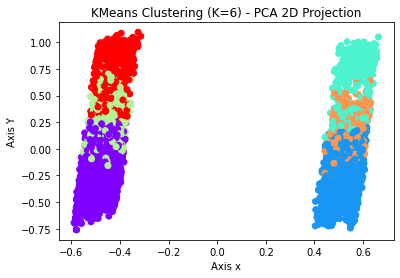

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Reduce the data to 2D using PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(mixed_playlist)

# Get the cluster labels assigned by KMeans
cluster_labels = model.labels_

# Create a scatter plot to visualize the clusters
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap='rainbow')
plt.title('KMeans Clustering (K=6) - PCA 2D Projection')
plt.xlabel('Axis x')
plt.ylabel('Axis Y')
plt.show()

In [31]:
# Initialize an empty list to store predictions
predictions = []
# Loop through each row in the DataFrame
for n in range(len(unknown_df)):
    # Access the nth row and reshape it to a 2D array
    row_data = unknown_df.iloc[n].values.reshape(1, -1)
    # Get the prediction and append it to the list
    prediction = model.predict(row_data)
    predictions.append(prediction[0])  # Assuming 'predict' returns a list or array
# Convert the list of predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
# Now 'predictions_df' is a DataFrame with all predictions
print(predictions_df)

predictions_df

    Prediction
0            5
1            5
2            2
3            5
4            5
..         ...
95           5
96           5
97           5
98           5
99           1

[100 rows x 1 columns]


,Prediction
0,5
1,5
2,2
3,5
4,5
...,...
95,5
96,5
97,5
98,5


In [32]:
# predictions_df['Prediction'].value_counts().get(0)
value_counts_df = predictions_df['Prediction'].value_counts().reset_index()
value_counts_df.columns = ['Prediction', 'Count']
value_counts_df = value_counts_df.sort_values(by='Prediction')
value_counts_df = value_counts_df.reset_index(drop=True)
value_counts_df


,Prediction,Count
0,0,16
1,1,11
2,2,28
3,3,9
4,4,4
5,5,32


In [ ]:
# Initialize an empty list to store predictions
predictions_test = []
# Loop through each row in the DataFrame
for n in range(len(mixed_playlist_complete)):
    # Access the nth row and reshape it to a 2D array
    row_data = unknown_df.iloc[n].values.reshape(1, -1)
    # Get the prediction and append it to the list
    prediction = model.predict(row_data)
    predictions.append(prediction[0])  # Assuming 'predict' returns a list or array
# Convert the list of predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
# Now 'predictions_df' is a DataFrame with all predictions
print(predictions_df)

predictions_df